This Jupyter notebook details theoretically the architecture and the mechanism of the Graph Convolutional Network (Gconv). Then, we implement the GCN model for node classification task using pytorch and networkx. <br> 
The notebook was implemented by <i>Nada Chaari</i>, PhD student at Istanbul Technical University (ITU). <br>

# Table of Contents:
    1)Why GCN and not CNN
    2)GCN architecture
    3)The spectral rule 
    4)Application of GCN using Karate dataset
        1-1) Loading Required Libraries
        1-2) Import Dataset
        1-3) Create the convolutional layer
        1-4) Create the CGN model using GCN layers
        1-5) Training the model using Karate dataset
        1-6) Evaluate the model using classification accuracy

Sources used to build this Jupiter Notebook:
* https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html
* https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-62acf5b143d0
* https://www.pushkarghanekar.com/blog/graph_nn/

# Why GCN and not CNN

* Convolutional Neural Networks (CNNs) can learn features from Euclidean data such as images. However, not all the data can be represented in Euclidian space. For example, in social network, friend connections can be realized using social graph. 


* A large percentage of machine learning (ML) problems will be much natural and effective to be modeled by graphs. In particular, when the relationships between neighboring nodes are irregular and high dimensional, we need to define them explicitly in order to solve them efficiently.


* Graph Convolutional Networks (GCNs) are powerful method for dealing with non-Euclidean data. The general idea of GCN is to apply convolution over a graph. Instead of having a 2-D array as input, GCN takes a graph as an input.

# GCN architecture

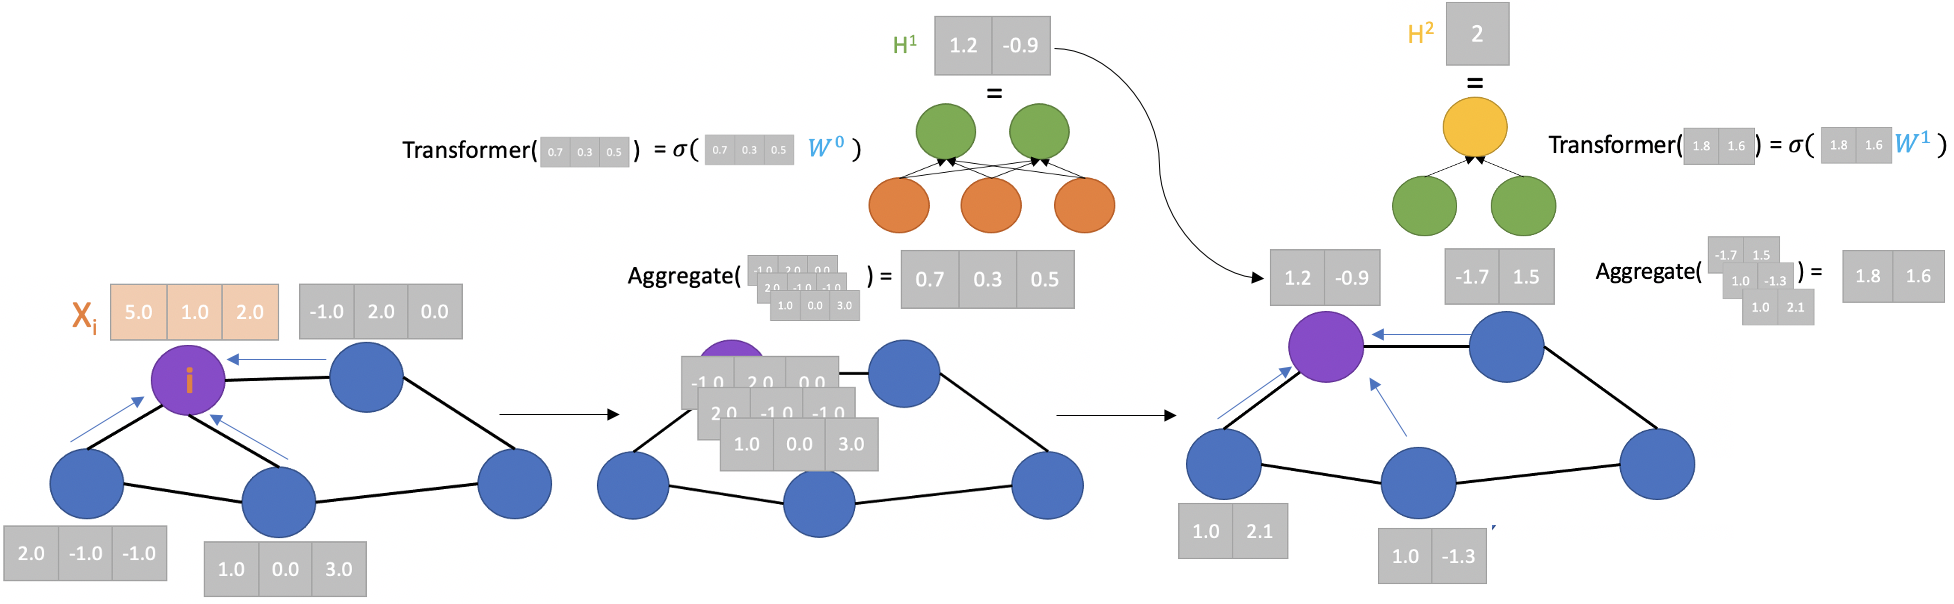

In [1]:
from IPython.display import Image
Image(filename = "/home/irekik/Downloads/detailed_GCN_layer.png", width = 1000, height = 700)

# The Spectral Rule

<img src='https://miro.medium.com/max/3200/1*2qWQawkWlpnQziHPzKNtfA@2x.png' width='400'  align="center">

* We transform the adjacency matrix A using the degree matrix D. However, as shown in Equation 3a, we raise the degree matrix to the power of -0.5 and multiply it on each side of A. This operation can be broken down as shown in Equation 3b. Recall again, that degree matrices are diagonal. We can therefore simplify Equation 3b further, until we reach the expression in Equation 3d.


* Equation 3d shows something quite interesting. When computing the aggregate feature representation of the ith node, we not only take into consideration the degree of the ith node, but also the degree of the jth node.


* The spectral rule normalizes the aggregate feature representation (remains  on the same scale as the input features). However, the spectral rule weighs neighbor in the weighted sum higher if they have a low-degree and lower if they have a high-degree. This may be useful when low-degree neighbors provide more useful information than high-degree neighbors.

 <font size="3"> <font color='darkblue'> The GCN model uses hybrid convolutions called  <font color='goldenrod'> spectral-rooted spatial convolutions </font> since it integrates an aggregation step that relies on the approximations of the spectral graph convolution (based on the Chebyshev polynomial expansion of the scaled graph Laplacian) and applies them in the spatial space, without computing the graph Fourrier.</font> </font>
 
source: https://arxiv.org/pdf/2003.11702.pdf

### General reformulation

Given an $N × F^0$ feature matrix $X$ and a matrix representation of the graph structure, e.g., the $N × N$ adjacency matrix $A$ of $G$, each hidden layer in the GCN can be expressed as $H^i = \sigma(H^{i-1}, A))$ where $ H^0 = X$ and $\sigma$ is a propagation rule. Each layer $H^i$ corresponds to an $N × F^i$ feature matrix where each row is a feature representation of a node.

The propagation rule computes the feature representation of a node as an aggregate of the feature representations of its neighbors before it is transformed by applying the weights $W^i$ and activation function $σ$. 

We can make the aggregation and transformation steps more explicit by expressing propagation rule as:
$\sigma(H^i, A) = transform(aggregate(A,H^i), W^i)$, where 
$transform(M, W^i) = σ(MW^i)$ and 
$ aggregate(A,H^i) = D^{-1/2}ÂD^{-1/2}H^i$

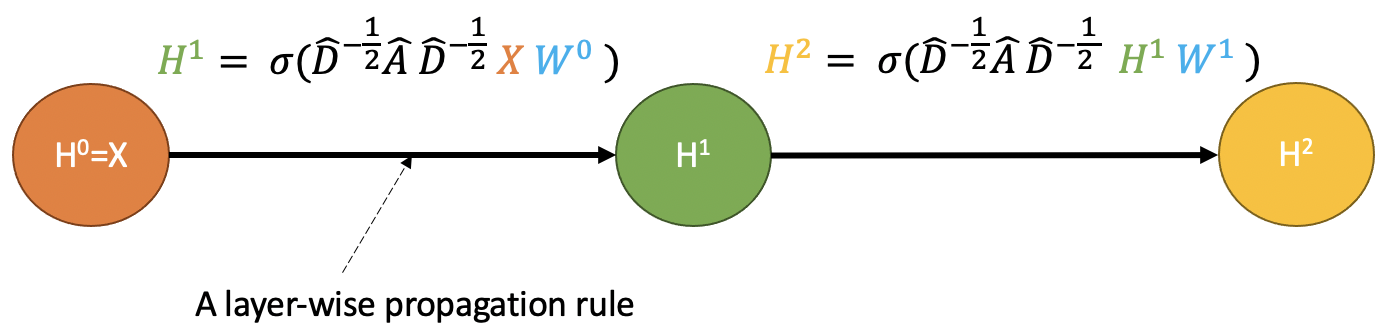

In [2]:
from IPython.display import Image
Image(filename = "/home/irekik/Downloads/GCN_layer.png", width = 1000, height = 500)

# Application of GCN using Karate dataset

#### Loading Required Libraries

In [3]:
import torch 
import matplotlib.pyplot as plt
import torch.nn as nn # create and train neural networks
import torch.optim as optim # optimize the nn using optimization functions
import networkx as nx #  for the creation, manipulation, and study of the structure and functions of complex networks.
from torch_geometric.utils import to_networkx # transfer a geometric dataset object to neworkx graph 
from torch_geometric.datasets import KarateClub # for loading the dataset KarateClub

#### Import Dataset

The dataset describes the social interaction of 34 members and the communities that rise from it, 4 in this case. Each members of the club is defined as a node. Each node is connected to other members in the club. This connection would determine the final grouping of the community in 4 separate labels.

Number of graphs: 1

Number of features: 34

Number of classes: 4

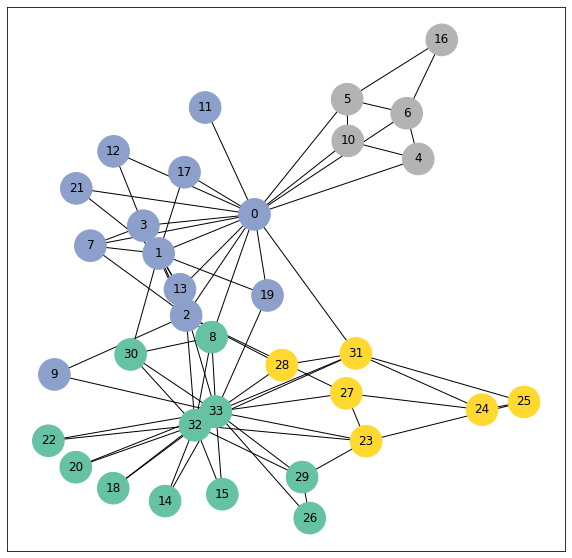

In [4]:
dataset = KarateClub()
G = to_networkx(dataset[0], to_undirected=True)
fig, ax = plt.subplots(1,1,figsize=(10,10))
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), node_size=10**3, with_labels=True, node_color=dataset[0].y, cmap="Set2", ax=ax)

In [48]:
dataset[0]

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])

#### Create the convolutional layer

First, we will be creating the GCNConv class, which will serve as the Layer creation class. Every instance of this class will be getting Adjacency Matrix as input and will be outputing 'RELU(A_hat X W)', which the Net class will use.

In [6]:
class GCNConv(nn.Module):
    def __init__(self, A, in_channels, out_channels):
        super(GCNConv, self).__init__()
        self.A_hat = A+torch.eye(A.size(0)) # A(adjacency)+I(identity) [dim = n*n] # indicate that all nodes are self-connected
        self.D     = torch.diag(torch.sum(A,1)) # diagonal of A (nodes degrees) [dim = n*n]
        self.D     = self.D.inverse().sqrt() # D^(-1/2) [dim = n*n]
        self.A_hat = torch.mm(torch.mm(self.D, self.A_hat), self.D) # for normalization to maintain the scale of the output feature vectors [dim = n*n]
        self.W     = nn.Parameter(torch.rand(in_channels,out_channels, requires_grad=True)) #initialization of the weights [dim = in_channels, out_channels]
      # D^(-1/2) * (A+I) * D^(-1/2) *  X  * W 

    def forward(self, X):
        out = torch.relu(torch.mm(torch.mm(self.A_hat, X), self.W)) # apply activation function (RELU)
        return out

#### Create the CGN model using GCN layers

The Net class will combine multiple Conv layer. In our case, the Net class consists of 2 GCN parts to account for the local information. The output of each convolution layer defines the updated nodes features which will be fed to the next convolution layer. Finally, the output of the second convolution layer is a matrix where the raw are the nodes  and the columns are scores of belonging to 4 classes.

In [7]:
class Net(torch.nn.Module):
    def __init__(self,A, nfeat, nhid, nout):
        super(Net, self).__init__()
        self.conv1 = GCNConv(A,nfeat, nhid) # nfeat= 34, nhid= 6
        self.conv2 = GCNConv(A,nhid, nout)  # nhid= 6, nhout= 4
    def forward(self,X):
        H  = self.conv1(X) # n is the number of training nodes  
                           #          D^(-1/2)*(A+I)*D^(-1/2)* X  *  W
                           # dim(H) =     n*n   n*n    n*n    n*34  34*6  =  [n*6]
        H2 = self.conv2(H) #          D^(-1/2)*(A+I)*D^(-1/2)* H  * W2  
                           # dim(H2)=     n*n   n*n    n*n    n*6  6*4  =  [n*4]
        return H2

In [8]:
Karate_adjacency = torch.Tensor(nx.to_numpy_matrix(G))
node_features = dataset[0].x
nhid = 6
nout = 4
# instanciate the GCN model
gcn_model = Net(Karate_adjacency, node_features.size(0), nhid, nout)
# define the CE loss 
criterion = torch.nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.SGD(gcn_model.parameters(), lr=0.01, momentum=0.9)

#### Training the model using Karate dataset

In [18]:
# the training set contains 4 nodes
losses = []
for i in range(5000):
    # forward pass on all the graph
    out = gcn_model(dataset[0].x)
    optimizer.zero_grad() # zero the parameter gradients
    # calculate the loss
    loss=criterion(out[dataset[0].train_mask], dataset[0].y[dataset[0].train_mask])
    loss.backward() # the backward propagates the error (loss) back into the network and update each weight and bias for each layer in the CNN using SGD optimizer
    optimizer.step()  # compute the SGD to find the next 
    if i % 1000==0:
        print("Step: {} Cross Entropy Loss = {}".format(i, loss.item()))
        losses.append(loss.item())
        output = gcn_model(dataset[0].x)

Step: 0 Cross Entropy Loss = 0.0023371002171188593
Step: 1000 Cross Entropy Loss = 0.0018478853162378073
Step: 2000 Cross Entropy Loss = 0.001519770361483097
Step: 3000 Cross Entropy Loss = 0.0012856610119342804
Step: 4000 Cross Entropy Loss = 0.0011108707403764129


Text(0.5, 1.0, 'loss distribution over the epochs')

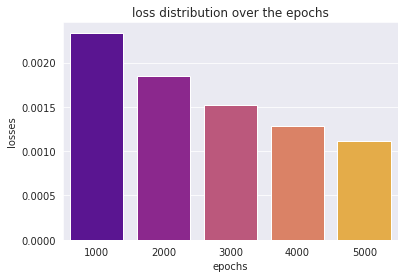

In [51]:
import pandas as pd  # Visualizing Statistical Data 
import seaborn as sns # Visualizing Statistical Data 
df = pd.DataFrame({'losses': losses, 'epochs': ['1000', '2000', '3000', '4000', '5000']})
sns.set_style('darkgrid')
# plot the accuracy classification for each class
ax = sns.barplot(x ='epochs', y ='losses', data = df, palette ='plasma')
ax.set_title('loss distribution over the epochs')

In [21]:
out[dataset[0].train_mask] # the output of the second hidden layer which represent the 
                           # scores belonging to 4 classes for each training nodes for the last epoch

tensor([[ 5.4134, 13.2872,  0.0000,  5.3717],
        [ 0.4319,  2.6371,  0.0000,  9.9094],
        [ 8.4487,  1.0950,  1.2126,  0.0000],
        [ 2.6319,  0.0000, 10.0884,  1.2415]], grad_fn=<IndexBackward>)

Text(0.5, 1.0, 'Output of the second hidden layer for node 1 in the training set')

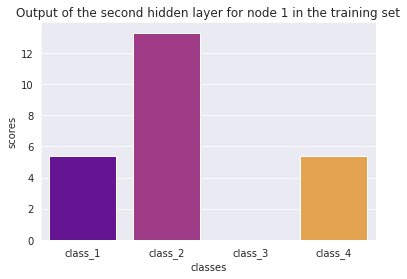

In [42]:
df = pd.DataFrame({'scores': out[dataset[0].train_mask][0,:].tolist(), 'classes': ['class_1', 'class_2', 'class_3', 'class_4']})
sns.set_style('darkgrid')
# plot the accuracy classification for each class
ax = sns.barplot(x ='classes', y ='scores', data = df, palette ='plasma')
ax.set_title('Output of the second hidden layer for node 1 in the training set')

Text(0.5, 1.0, 'Output of the second hidden layer for node 2 in the training set')

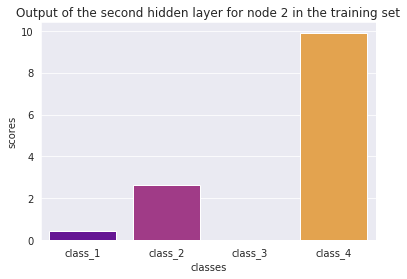

In [41]:
df = pd.DataFrame({'scores': out[dataset[0].train_mask][1,:].tolist(), 'classes': ['class_1', 'class_2', 'class_3', 'class_4']})
sns.set_style('darkgrid')
# plot the accuracy classification for each class
ax = sns.barplot(x ='classes', y ='scores', data = df, palette ='plasma')
ax.set_title('Output of the second hidden layer for node 2 in the training set')

Text(0.5, 1.0, 'Output of the second hidden layer for node 3 in the training set')

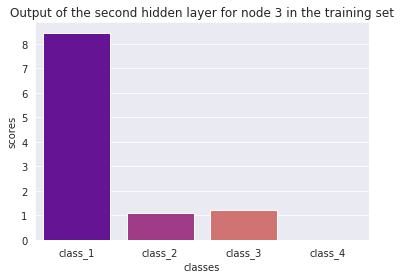

In [45]:
df = pd.DataFrame({'scores': out[dataset[0].train_mask][2,:].tolist(), 'classes': ['class_1', 'class_2', 'class_3', 'class_4']})
sns.set_style('darkgrid')
# plot the accuracy classification for each class
ax = sns.barplot(x ='classes', y ='scores', data = df, palette ='plasma')
ax.set_title('Output of the second hidden layer for node 3 in the training set')

Text(0.5, 1.0, 'Output of the second hidden layer for node 4 in the training set')

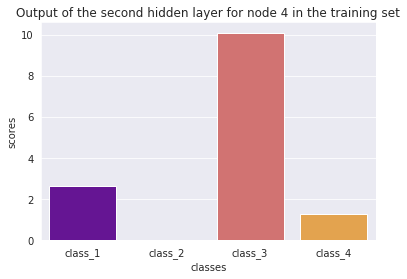

In [46]:
df = pd.DataFrame({'scores': out[dataset[0].train_mask][3,:].tolist(), 'classes': ['class_1', 'class_2', 'class_3', 'class_4']})
sns.set_style('darkgrid')
# plot the accuracy classification for each class
ax = sns.barplot(x ='classes', y ='scores', data = df, palette ='plasma')
ax.set_title('Output of the second hidden layer for node 4 in the training set')

#### Test the model using classification accuracy

In [22]:
# the dataset is divided by default to training (4 nodes) and testing (30 nodes) sets
out[dataset[0].train_mask==False] # the output of the second hidden layer which represent the 
                           # scores belonging to 4 classes for each testing nodes for the last epoch

tensor([[7.0594e+00, 9.3422e+00, 0.0000e+00, 2.4830e-01],
        [7.5375e+00, 4.6613e+00, 5.4515e-01, 2.8461e-03],
        [5.3542e+00, 8.6391e+00, 0.0000e+00, 3.4799e-01],
        [6.5259e-02, 3.2398e+00, 0.0000e+00, 1.1292e+01],
        [3.6947e-02, 3.3171e+00, 0.0000e+00, 1.1174e+01],
        [4.9184e+00, 6.3976e+00, 0.0000e+00, 4.3162e-01],
        [6.7859e+00, 1.0285e+00, 1.5569e+00, 0.0000e+00],
        [4.1709e-01, 2.7881e+00, 0.0000e+00, 9.6294e+00],
        [1.9530e+00, 1.7634e+01, 0.0000e+00, 6.3673e-01],
        [3.6019e+00, 8.1290e+00, 0.0000e+00, 1.0480e+00],
        [5.7556e+00, 5.1778e+00, 0.0000e+00, 3.0678e-01],
        [6.3190e+00, 0.0000e+00, 3.7263e+00, 0.0000e+00],
        [6.7259e+00, 0.0000e+00, 3.9059e+00, 0.0000e+00],
        [0.0000e+00, 2.5179e+00, 0.0000e+00, 1.1159e+01],
        [3.8432e+00, 6.6402e+00, 0.0000e+00, 1.0913e+00],
        [6.9924e+00, 0.0000e+00, 3.9652e+00, 0.0000e+00],
        [4.8815e+00, 4.0413e+00, 0.0000e+00, 5.2642e-01],
        [7.119

In [23]:
test_labels = dataset[0].y[dataset[0].train_mask==False] 
test_preds = torch.argmax(out[dataset[0].train_mask==False], dim=1) 
# predict the class of each node in the testing set by taking the maximing score
# among the 4 scores assogned for each class for each node by the 2 hidden layer

In [24]:
test_preds # predicted class labels

tensor([1, 0, 1, 3, 3, 1, 0, 3, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 1, 0, 2, 2, 2, 2,
        0, 2, 0, 2, 0, 0])

In [25]:
test_labels # ground truth

tensor([1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 2, 2, 0, 2,
        2, 0, 0, 2, 0, 0])

In [26]:
# calculate the classification accuracy of GCN model 
correct = 0
for i in range(len(test_preds)):
    if test_preds[i] == test_labels[i]:
        correct+=1
acc = correct/len(test_labels)
print(acc)

0.7666666666666667
